# 振子のパラメータ同定

In [34]:
import math
import copy
import numpy as np
import pandas as pd
import sympy as sp
import matplotlib.pyplot as plt
import control
import datetime

from decimal import *
from control import tf, tfdata, matlab
from control.matlab import *
from scipy import signal
from scipy.integrate import odeint

from scipy.linalg import solve_continuous_are
from scipy.integrate import solve_ivp
import scipy.constants as cnst

from Modules import Modules
modules = Modules('')

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

print("OK\n")

OK



In [35]:
# LPF
def lowpass(x, samplerate, fp, fs, gpass, gstop):
    fn = samplerate / 2   #ナイキスト周波数
    wp = fp / fn  #ナイキスト周波数で通過域端周波数を正規化
    ws = fs / fn  #ナイキスト周波数で阻止域端周波数を正規化
    N, Wn = signal.buttord(wp, ws, gpass, gstop)  #オーダーとバターワースの正規化周波数を導出
    b, a = signal.butter(N, Wn, "low")            #フィルタ伝達関数の分子と分母を導出
    y = signal.filtfilt(b, a, x)                  #信号に対してフィルタを適用
    return y  

In [36]:
# 近似
def calc_poly(df_value):
    # 近似式の係数
    y = df_value
    res1=np.polyfit(x, y, 1)
    res2=np.polyfit(x, y, 2)
    res3=np.polyfit(x, y, 3)
    # 近似式の計算
    y1 = np.poly1d(res1)(x) #1次
    y2 = np.poly1d(res2)(x) #2次
    y3 = np.poly1d(res3)(x) #3次
    
    # グラフ描画
    plt.scatter(x, y, label='元データ')
    plt.plot(x, y1, label='1次')
    plt.plot(x, y2, label='2次')
    plt.plot(x, y3, label='3次')
    plt.legend()
    plt.show()
    return y1,y2,y3

In [37]:
# 2次系伝達関数モデル作成
def tf_2nd_order(zeta, wn):
   num = [math.pow(wn, 2)]
   den = [1, 2*zeta*wn, math.pow(wn, 2)]
   G = matlab.tf(num, den)
   return G

In [38]:
# 最大値を取得
def get_peak(output, t):
    t_peak = 0
    a_max = 0
    for i, y in enumerate(output):
        if y > a_max:
            a_max = y
            t_peak = t[i]
    return a_max, t_peak

In [39]:
# am,bmを導出
def calc_param_ab(a_max, t_peak, Kp, z_c):
    gumma_c = (1/t_peak) * math.log1p((z_c/a_max))
    delta_c = math.pi/t_peak
    omega_nc = math.sqrt(math.pow(gumma_c, 2) + math.pow(delta_c, 2))
    zeta_c = gumma_c/omega_nc
    print("omega_nc : " +str(omega_nc))
    print("zeta_c : " + str(zeta_c))
    a_m = 2 * zeta_c * omega_nc
    b_m = ((math.pow(omega_nc, 2))/Kp)
    return a_m, b_m

In [40]:
# グラフ描画
def plot_line(output, t, z_c, x_max, y_max):
    # 出力パラメータ
    plt.plot(t, z_c * output)
    plt.axhline(z_c, ls=":", color="blue")
    
    # グラフ表示設定
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.title('2nd order step', fontsize=10)
    plt.xlabel('time [sec]', fontsize=10)
    plt.ylabel('Output', fontsize=10)
    plt.xlim([0, x_max])
    plt.ylim([0, y_max])
    plt.tick_params(labelsize = 10)
    plt.tight_layout()
    plt.grid()
    plt.show()

In [41]:
# グラフ描画
def result_plot(x, u, t):
    fig=plt.figure()

    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4)
    
    ax1.plot(t, x[:, 0], c = 'k')
    ax2.plot(t, x[:, 1], c = 'k')
    ax3.plot(t, x[:, 2], c = 'k')
    ax4.plot(t, x[:, 3], c = 'k')
    
    ax1.set_xlabel(r"$t$")
    ax2.set_xlabel(r"$t$")
    ax3.set_xlabel(r"$t$")
    ax4.set_xlabel(r"$t$")
    ax1.set_ylabel(r"$\theta_{1}$")
    ax2.set_ylabel(r"$\theta_{\mathrm{w}}$")
    ax3.set_ylabel(r"${\theta}^{(1)}_{1}$")
    ax4.set_ylabel(r"${\theta}^{(1)}_{\mathrm{w}}$")
    
    fig.tight_layout()
    plt.show()
    
    fig2=plt.figure()
    ax_u = fig2.add_subplot(1,1,1)
    ax_u.plot(t, u, c = 'k')
    ax_u.set_xlabel(r"$t$")
    ax_u.set_ylabel(r"$u$")
    plt.show()
    return True

## データの読み込み

<Axes: >

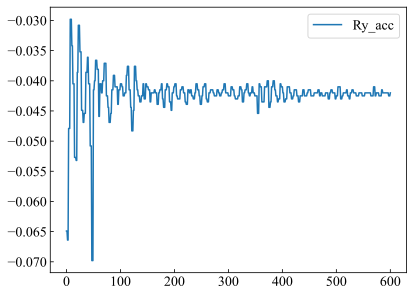

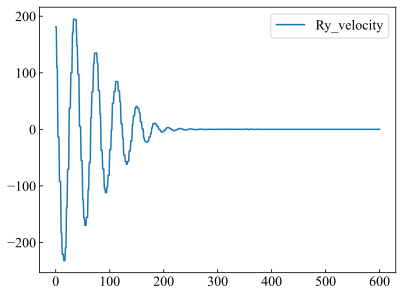

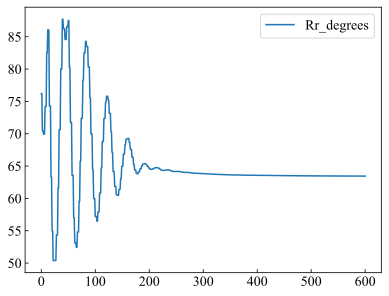

In [42]:
### サンプリング周波数200[Hz]で観測したデータ
#df = pd.read_csv('./param_ev3-005_1699278939.335626.tsv')
df = pd.read_csv('/home/uecadmin/researchScript/param_ev3-007_1699595979.0359282.tsv')
df.plot(y='Ry_acc')
df.plot(y='Ry_velocity')
df.plot(y='Rr_degrees')

### 実験データの⊿tを配列化

In [43]:
time = 0
TimeSeries = []
for index, row in df.iterrows():
    if index == 0:
        TimeSeries.append(0)
    else:
        TimeSeries.append(TimeSeries[index - 1] + row['delta'])
    time = time + row['delta']
samplerate = 1.0 / (time / 600)
endtime = time

## 振り子の自由振動/減衰系のシュミレーション

In [44]:
### 実験結果からパラメータを取得
velocity = df['Ry_velocity'].values
degrees = df['Rr_degrees'].values
max_degress = max(degrees)
min_degress = min(degrees)
last_degrees = degrees[600]
offset = last_degrees
print(max_degress - last_degrees)
print(last_degrees - min_degress)
print(max_degress - min_degress)

24.251999999999995
13.062999999999995
37.31499999999999


In [45]:
### 振り子の自由振動
def wave_sym(t, v, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0) + offset
    # sol[0]が変位x1, sol[1]が速度x2となる
    #return [deg, v]
    return deg

In [46]:
### 可観測パラメータを定義
am = 16.00141903925736
bm = 11.113081880504575

g = 9.81     # 重力加速度
M = 0.75     # 振子の質量
m = 0.15    # タイヤの質量
lp = 0.08    # 重心位置から車軸の距離
rw = 0.040

24.251999999999995


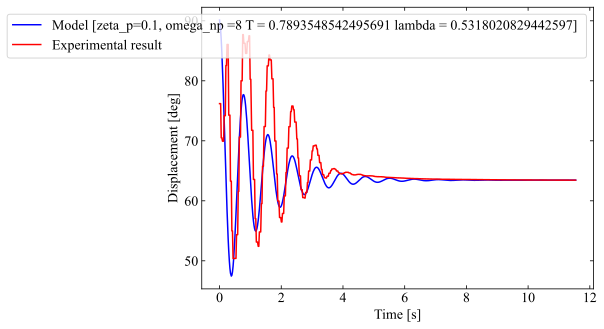

In [47]:
### 実験結果とサンプリング周波数,タイムスケールを同期させたシミュレート
t0 = TimeSeries[0]
t = TimeSeries
time = TimeSeries
zeta_p = 0.1
omgega_np = 8
theta_0 = max_degress - last_degrees
print(theta_0)
sol = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    sol.append(wave_sym(time[index], velocity[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# グラフ描画
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Displacement [deg]')

# データプロット
## 計算値
ax1.plot(time, sol, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')
## 実験結果
ax1.plot(TimeSeries, df['Rr_degrees'].values, label='Experimental result', c='r')

fig.tight_layout()
plt.legend(loc='upper right')

# グラフを表示する。
plt.show()
plt.close()

In [48]:
### 振り子の自由振動
def wave_sym2(t, zeta_p, omgega_np, theta_0, offset):
    omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))
    deg = (np.exp(- zeta_p * omgega_np * t) * (np.cos(omega_dp * t) + (zeta_p/np.sqrt(1 - np.power(zeta_p, 2) * np.sin(omega_dp * t)))) * theta_0)
    return deg

0.7893548542495691
0.5318020829442597
I : 0.004396875


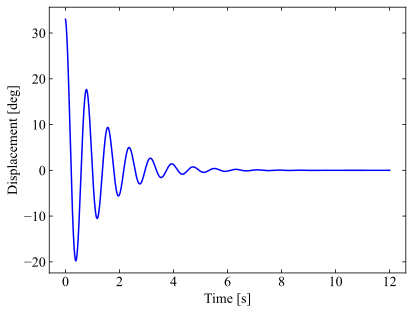

In [49]:
### データポイントを増やしてシミュレート
t0 = 0
et = 12
dt = 0.001
time = np.arange(t0, (et+dt), dt)
theta_0 = 30

# ---------------------------------------------------------------------- #
# mode 01
# ---------------------------------------------------------------------- #
zeta_p = 0.1
omgega_np = 8
mode1 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode1.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))
print(T)
print(lamb)

# ---------------------------------------------------------------------- #
# Iを導出
# ---------------------------------------------------------------------- #
I = (M*g*lp)/(np.power(omgega_np, 2)) - M * np.power(lp, 2)
print('I : ' + str(I))

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
# フォントの種類とサイズを設定
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# 目盛を設定
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig = plt.figure()
ax2 = fig.add_subplot(111)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')

# 軸のラベルを設定する。
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Displacement [deg]')
ax2.plot(time, mode1, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='b')

# ---------------------------------------------------------------------- #
# mode 02
# ---------------------------------------------------------------------- #
zeta_p = 0.2
omgega_np = 10
theta_0 = max_degress - last_degrees
mode2 = []
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# ---------------------------------------------------------------------- #
# Φ(t)を導出
# ---------------------------------------------------------------------- #
for index, t in enumerate(time):
    mode2.append(wave_sym2(time[index], zeta_p, omgega_np, theta_0, offset))

# ---------------------------------------------------------------------- #
# 周期T,減衰率λの導出
# ---------------------------------------------------------------------- #
T = (2 * math.pi)/omega_dp
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

# ---------------------------------------------------------------------- #
# データプロット
# ---------------------------------------------------------------------- #
## 計算値
#ax2.plot(time, mode2, label='Model [zeta_p=' + str(zeta_p) + ', omega_np =' + str(omgega_np) + ' T = ' + str(T) + ' lambda = ' + str(lamb) + '] ', c='g')


# グラフを表示する。
plt.show()
plt.close()

## モータの角加速度を制御する

### 最適レギュレータによるゲイン導出

In [74]:
### パラメータ導出
Kv = 1.0
r_omega = 0.026
#### 周期T,減衰率λ
zeta_p = 0.1
omgega_np = 8

# ωdp
omega_dp = omgega_np * np.sqrt(1 - np.power(zeta_p, 2))

# Tpeak
T_peak = (2 * math.pi)/omega_dp
# λ
lamb = np.exp(- (2 * math.pi * zeta_p)/(np.sqrt(1 - np.power(zeta_p, 2))))

#### γ,δp
gumma_p = (1/T_peak) * np.log(1/lamb)
delta_p = (2 * math.pi) / T_peak
#### ωnp,ζp
omega_np = np.sqrt(np.power(gumma_p, 2) + np.power(delta_p, 2))
print('ωnp : ' + str(omega_np))
zeta_p = gumma_p/omega_np

#### (I + J + m・r^2_ω + M・lp^2 + 2Mlpr_ω)
param1 = (M * g * lp)/np.power(omega_np, 2)

#### μp
mu_p = -2 * omega_np * zeta_p * param1

# α,β
alpha = np.power(omega_np, 2)/Kv
#alpha = (M * g * lp)/param1
beta = (-1 * mu_p) / param1

#J,(J + mrω^2 + Mrω^2 + Mlprω)
#J = (param1 - I - ((M + m) * np.power(rw, 2)) - M * np.power(lp, 2) - 2*M*lp*rw)
J = m * np.power(rw, 2) / 2 
print('J : ' + str(J))

param2 = J + (m * np.power(r_omega, 2)) + (M * np.power(r_omega, 2)) + (M * lp * r_omega)

# gumma
gumma = (am * param2)/param1
delta = (-bm * param2)/param1

print('α : ' + str(alpha))
print('β : ' + str(beta))
print('γ : ' + str(gumma))
print('δ : ' + str(delta))

### 最適レギュレータ

A = [[0, 1, 0, 0]
     ,[alpha, beta, 0, gumma]
     ,[0, 0, 0, 1]
     ,[0, 0, 0, -am]]
B = [[0]
    ,[delta]
    ,[0]
    ,[bm]]
Q = [[10, 0, 0, 0]
    ,[0, 10, 0, 0]
    ,[0, 0, 100, 0]
    ,[0, 0, 0, 10]]
# 4x4の単位行列を生成
C = np.eye(4)
# 4x1の零行列を生成
D = np.zeros([4, 1])


P = ss(A, B, C, D)
R = 1
F,X,E = lqr(P.A, P.B, Q, R)
F = -F

print('---- フィードバックゲイン ----')
print(F)
print(-(1/R) * P.B.T * X)

print('---- 閉ループ系 ----')
print(E)
print(np.linalg.eigvals(A + B * F))

ωnp : 8.0
J : 0.00012
α : 64.0
β : 1.6
γ : 3.9176965096345135
δ : -2.7236138002127346
---- フィードバックゲイン ----
[[336.61649905  46.5878107   10.           7.43343183]]
[[336.61649905  46.5878107   10.           7.43343183]]
---- 閉ループ系 ----
[-39.71244075+0.j          -2.88506262+0.j
  -7.87983244+0.52109122j  -7.87983244-0.52109122j]
[-39.71244075+0.j          -2.88506262+0.j
  -7.87983244+0.52109122j  -7.87983244-0.52109122j]


### ゲインを適用しない場合

True

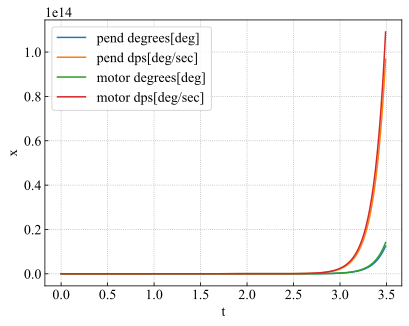

In [75]:
# 状態フィードバックゲインなし
Acl = P.A + P.B 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 3.5, 0.01)
X0 = [24, velocity[0], 0, 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
ax.plot(t, x[:,2], label = 'motor degrees[deg]')
ax.plot(t, x[:,3], label = 'motor dps[deg/sec]')
modules.plot_set(ax, 't', 'x', 'best')

#### ゲインを適用する場合

True

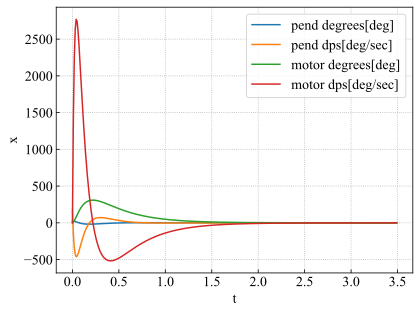

In [76]:
# 最適レギュレータにより導出した状態フィードバックゲインを適用する
#dps_a = df_motor['dps_a'].values
#a_position = df_motor['a_position'].values
#pos = a_position[1]/360

Acl = P.A + P.B*F 
Pfb = ss(Acl, P.B, P.C, P.D)

Td = np.arange(0, 3.5, 0.01)
X0 = [24, velocity[0], 0, 0]

x, t = initial(Pfb, Td, X0)

fig, ax = plt.subplots()
ax.plot(t, x[:,0], label = 'pend degrees[deg]')
ax.plot(t, x[:,1], label = 'pend dps[deg/sec]')
ax.plot(t, x[:,2], label = 'motor degrees[deg]')
ax.plot(t, x[:,3], label = 'motor dps[deg/sec]')
modules.plot_set(ax, 't', 'x', 'best')

In [77]:
### 可制御性の確認 
Uc = ctrb(P.A, P.B)
print('Uc=\n', Uc)
print('det(Uc)=', np.linalg.det(Uc))
print('rank(Uc)=', np.linalg.matrix_rank(Uc))

Uc=
 [[ 0.00000000e+00 -2.72361380e+00  3.93804974e+01 -8.13691752e+02]
 [-2.72361380e+00  3.93804974e+01 -8.13691752e+02  1.24980538e+04]
 [ 0.00000000e+00  1.11642848e+01 -1.79286288e+02  2.87914306e+03]
 [ 1.11642848e+01 -1.79286288e+02  2.87914306e+03 -4.62359106e+04]]
det(Uc)= 3787152.6610105666
rank(Uc)= 4


In [78]:
# Controllability
Wc = ctrb(P.A, P.B)
a = np.mat(P.A)
print("Wc = ", Wc)
if np.linalg.matrix_rank(Wc) != a.shape[0]:
   print ("System not Controllability\n")
else :
   print ("System Controllability\n")

Wc =  [[ 0.00000000e+00 -2.72361380e+00  3.93804974e+01 -8.13691752e+02]
 [-2.72361380e+00  3.93804974e+01 -8.13691752e+02  1.24980538e+04]
 [ 0.00000000e+00  1.11642848e+01 -1.79286288e+02  2.87914306e+03]
 [ 1.11642848e+01 -1.79286288e+02  2.87914306e+03 -4.62359106e+04]]
System Controllability



## 離散時間最適レギュレータ導出

In [79]:
Q = np.diag([10,10,100,10])
R = 1

Uc = ctrb(P.A, P.B)
rankUc = np.linalg.matrix_rank(Uc)
print(rankUc)

N = P.A.shape[0]

f, pp, e = lqr(P.A, P.B, Q, R)

print("f = ", f)

4
f =  [[-336.61649905  -46.5878107   -10.           -7.43343183]]


[-39.71244075+0.j          -2.88506262+0.j
  -7.87983244+0.52109122j  -7.87983244-0.52109122j]


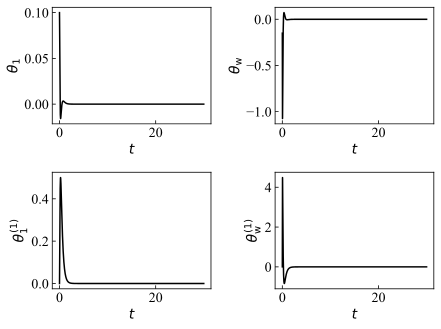

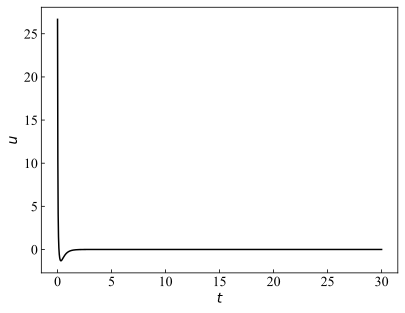

True

In [80]:
Acl = P.A - P.B @ f
fbcsys = ss(Acl, P.B, P.C, P.D)

print(pole(fbcsys))

x0 = np.array([0.1, -0.15, 0.0, 0.0]).reshape(-1, 1)
Tc = np.arange(0, 30, 0.001)
x, t = initial(fbcsys, Tc, x0)

u = -f @ x.T
u = u.T

result_plot(x, u, t)

In [81]:
T = 0.015
dsys = c2d(P, T, method='zoh')
print(dsys)

<LinearIOSystem>: sys[63]$sampled
Inputs (1): ['u[0]']
Outputs (4): ['y[0]', 'y[1]', 'y[2]', 'y[3]']
States (4): ['x[0]', 'x[1]', 'x[2]', 'x[3]']

A = [[1.00726667e+00 1.52179101e-02 0.00000000e+00 4.11237490e-04]
     [9.73946243e-01 1.03161533e+00 0.00000000e+00 5.30151256e-02]
     [0.00000000e+00 0.00000000e+00 1.00000000e+00 1.33301033e-02]
     [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.85933018e-01]]

B = [[-0.0002859 ]
     [-0.03685654]
     [ 0.00116093]
     [ 0.14882107]]

C = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]

D = [[0.]
     [0.]
     [0.]
     [0.]]

dt = 0.015



In [82]:
#Q = np.diag([100, 10, 1, 10])
#R = 10000000

Ucd = ctrb(dsys.A, dsys.B)
rankUcd = np.linalg.matrix_rank(Ucd)
Nd = dsys.A.shape[0]
fd, Pd, ed = dlqr(dsys.A, dsys.B, Q, R)
print(rankUcd)

4


[0.55512918 0.95764124 0.88852759 0.88852759]


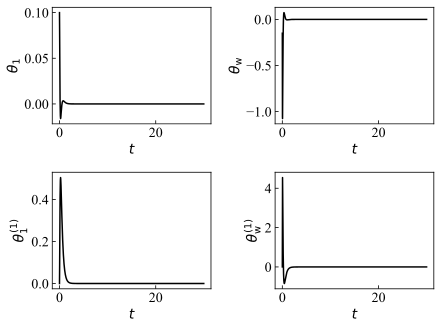

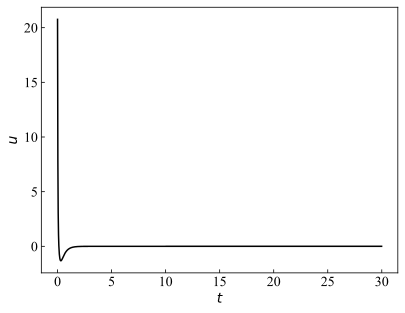

True

In [83]:
Adl = dsys.A - dsys.B @ fd
fbdsys = ss(Adl, dsys.B, dsys.C, dsys.D, dsys.dt)

print(abs(pole(fbdsys)))

x0 = np.array([0.1, -0.15, 0.0, 0.0]).reshape(-1, 1)
Td = np.arange(0, 30, dsys.dt)
xd, td = initial(fbdsys, Td, x0)
ud = -fd @ xd.T
ud = ud.T

result_plot(xd, ud, td)

In [84]:
-fd

matrix([[261.97860365,  36.24874711,   7.2204633 ,   5.82898032]])

### PID制御器の検討

In [61]:
am = 8.272856311536618
bm = 2.4549525908389445
a1 = bm
a2 = (gumma + am) * bm
b1 = (am - beta)
b2 = - (am * beta + alpha)
b3 = - (am * alpha)
print('a1 : ' + str(a1))
print('b1 : ' + str(b1))
print('b2 : ' + str(b2))
print('b3 : ' + str(b3))
bm*gumma

a1 : 2.4549525908389445
b1 : 6.672856311536618
b2 : -77.23657009845859
b3 : -529.4628039383435


9.774471022149045

In [62]:
### パラメータ定義
am = 16.05891389967057
bm = 11.164284779591377
g = 9.81     # 重力加速度
M = 0.94     # 振子の質量
m = 0.15    # タイヤの質量
lp = 0.08    # 重心位置から車軸の距離


Np = [a1, a2]
Dp = [1, b1, b2, b3]

P = control.tf(Np, Dp)
P

TransferFunction(array([ 2.45495259, 30.08394106]), array([   1.        ,    6.67285631,  -77.2365701 , -529.46280394]))

True

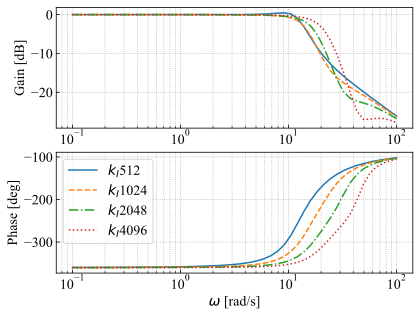

In [63]:
# 目標値
ref = 90

Kp = 40
Kd = 2
Ki = (512, 1024, 2048, 4096)

LS = modules.linestyle_generator()
fig,ax = plt.subplots(2, 1)
for i in range(len(Ki)):
    K = control.tf([Kd, Kp, Ki[i]], [1, 0])
    Gyr = feedback(P*K, 1)
    gain, phase, w = bode(Gyr, logspace(-1, 2), plot=False)
    
    pltargs = {'ls': next(LS), 'label': '$k_I$'+str(Ki[i])}
    ax[0].semilogx(w, 20*np.log10(gain), **pltargs)
    ax[1].semilogx(w, phase*180/np.pi, **pltargs)
modules.bodeplot_set(ax, 'best')

True

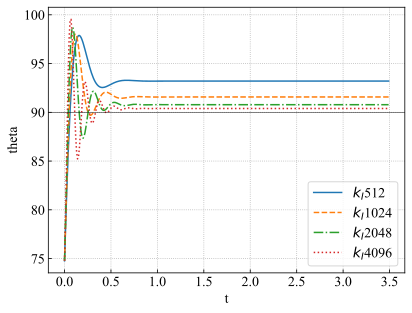

In [64]:
LS = modules.linestyle_generator()
fig,ax = plt.subplots()
for i in range(len(Ki)):
    K = control.tf([Kd, Kp, Ki[i]], [1])
    Gyr = feedback(P*K, 1)
    y, t = step(Gyr, np.arange(0, 3.5, 0.01))
    pltargs = {'ls': next(LS), 'label': '$k_I$'+str(Ki[i])}
    ax.plot(t, y*ref, **pltargs)
ax.axhline(ref, color="k", linewidth=0.5)
modules.plot_set(ax, 't', 'theta', 'best')